In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import optuna

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from tqdm.notebook import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR, SGDClassifier as SGD
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler
from sklearn.model_selection import KFold as KF, StratifiedKFold as SKF, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier as RF, VotingClassifier
from xgboost import XGBRFClassifier as xgb
from lightgbm import LGBMClassifier as lgb
from collections import Counter
from multiprocessing import Pool, Lock, Process

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv("./creditcard.csv")

In [ ]:
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
print(data.shape)
data.describe()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [19]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
missing_cnt = data.isnull().sum()
print(missing_cnt[missing_cnt > 0],end='\n\n')

Series([], dtype: int64)



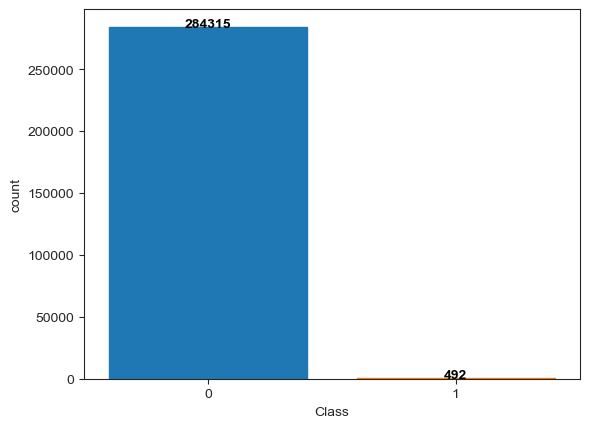

In [19]:
ax = sns.countplot(x=data['Class'], data = data)
# 通过bar_list得到每一个条形
bars = ax.patches

# 为每个条形设置不同的颜色
for i, bar in enumerate(bars):
    bar.set_color(f"C{i}")
    
# 在条形上标注数值    
for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height(), 
        round(bar.get_height()),
        horizontalalignment='center', 
        color='black', 
        weight='bold'
    )

<Axes: >

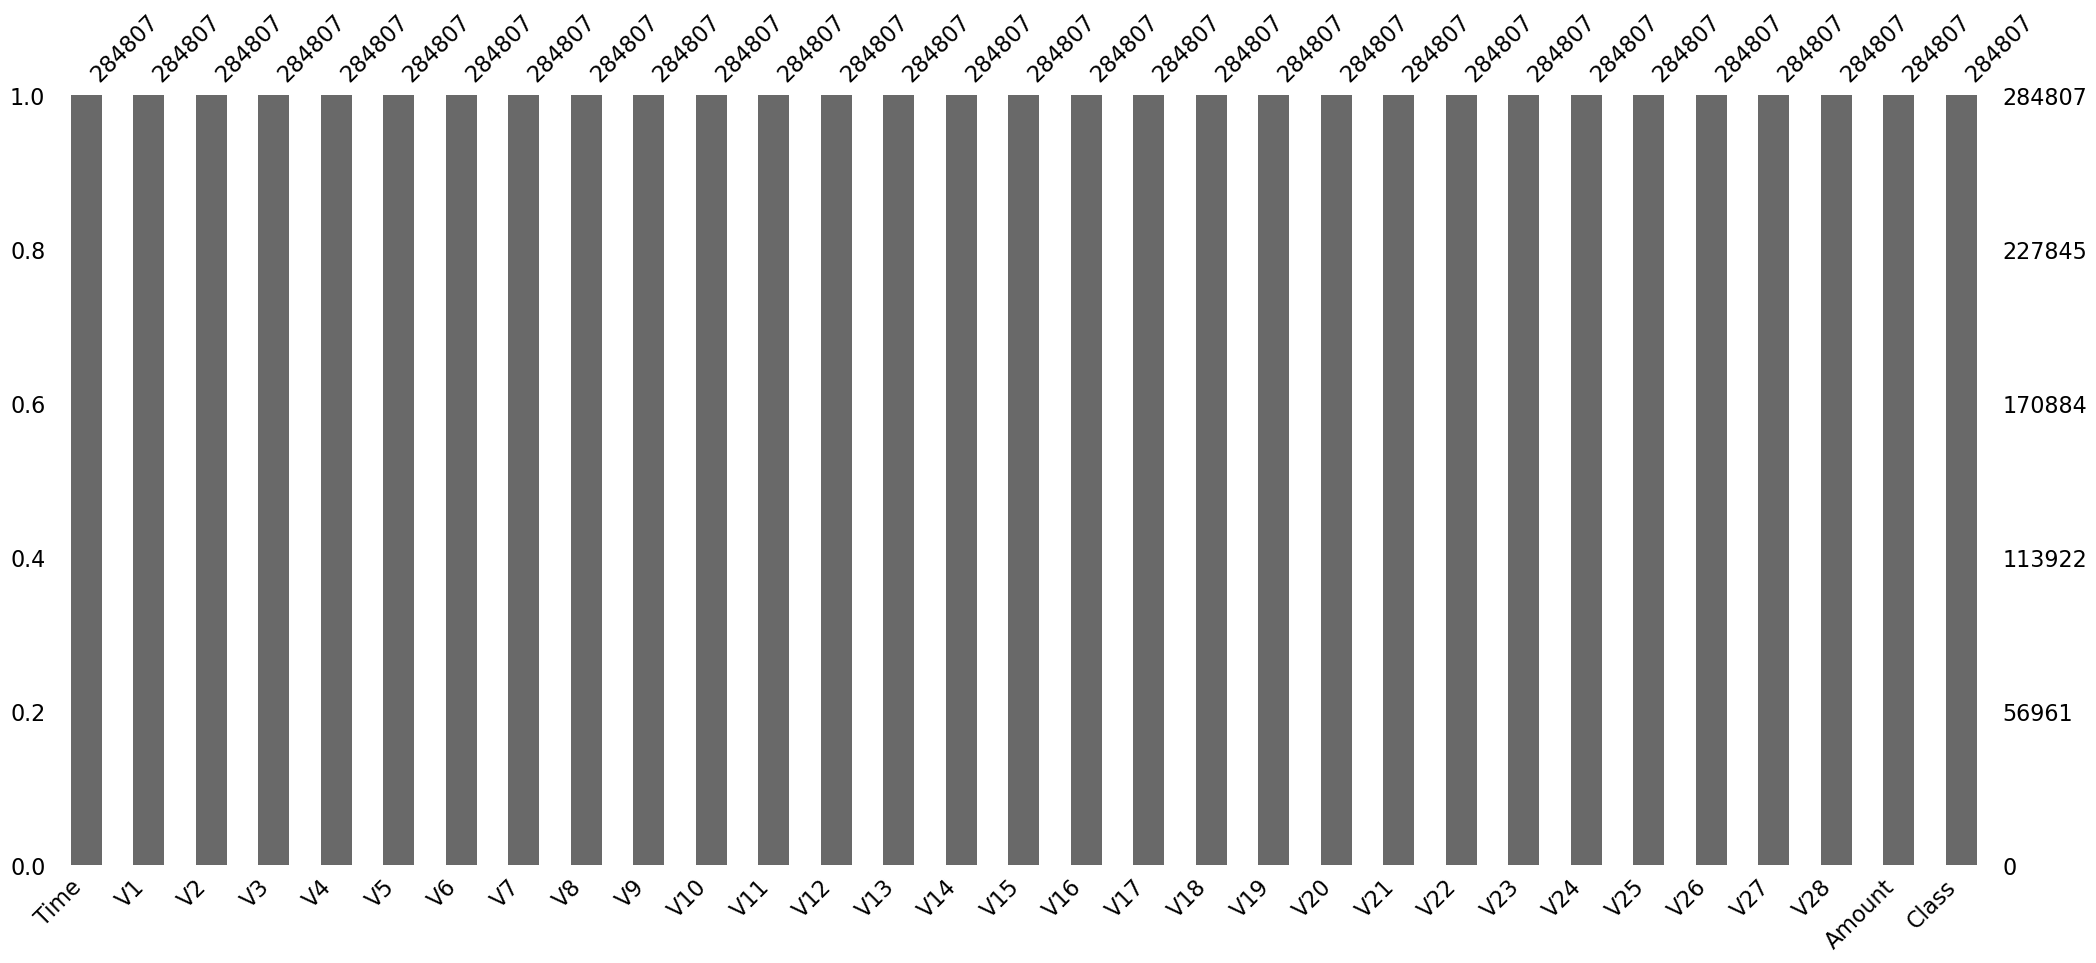

In [12]:
msno.bar(data)

In [3]:
# 对Time、Amount做标准化处理
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

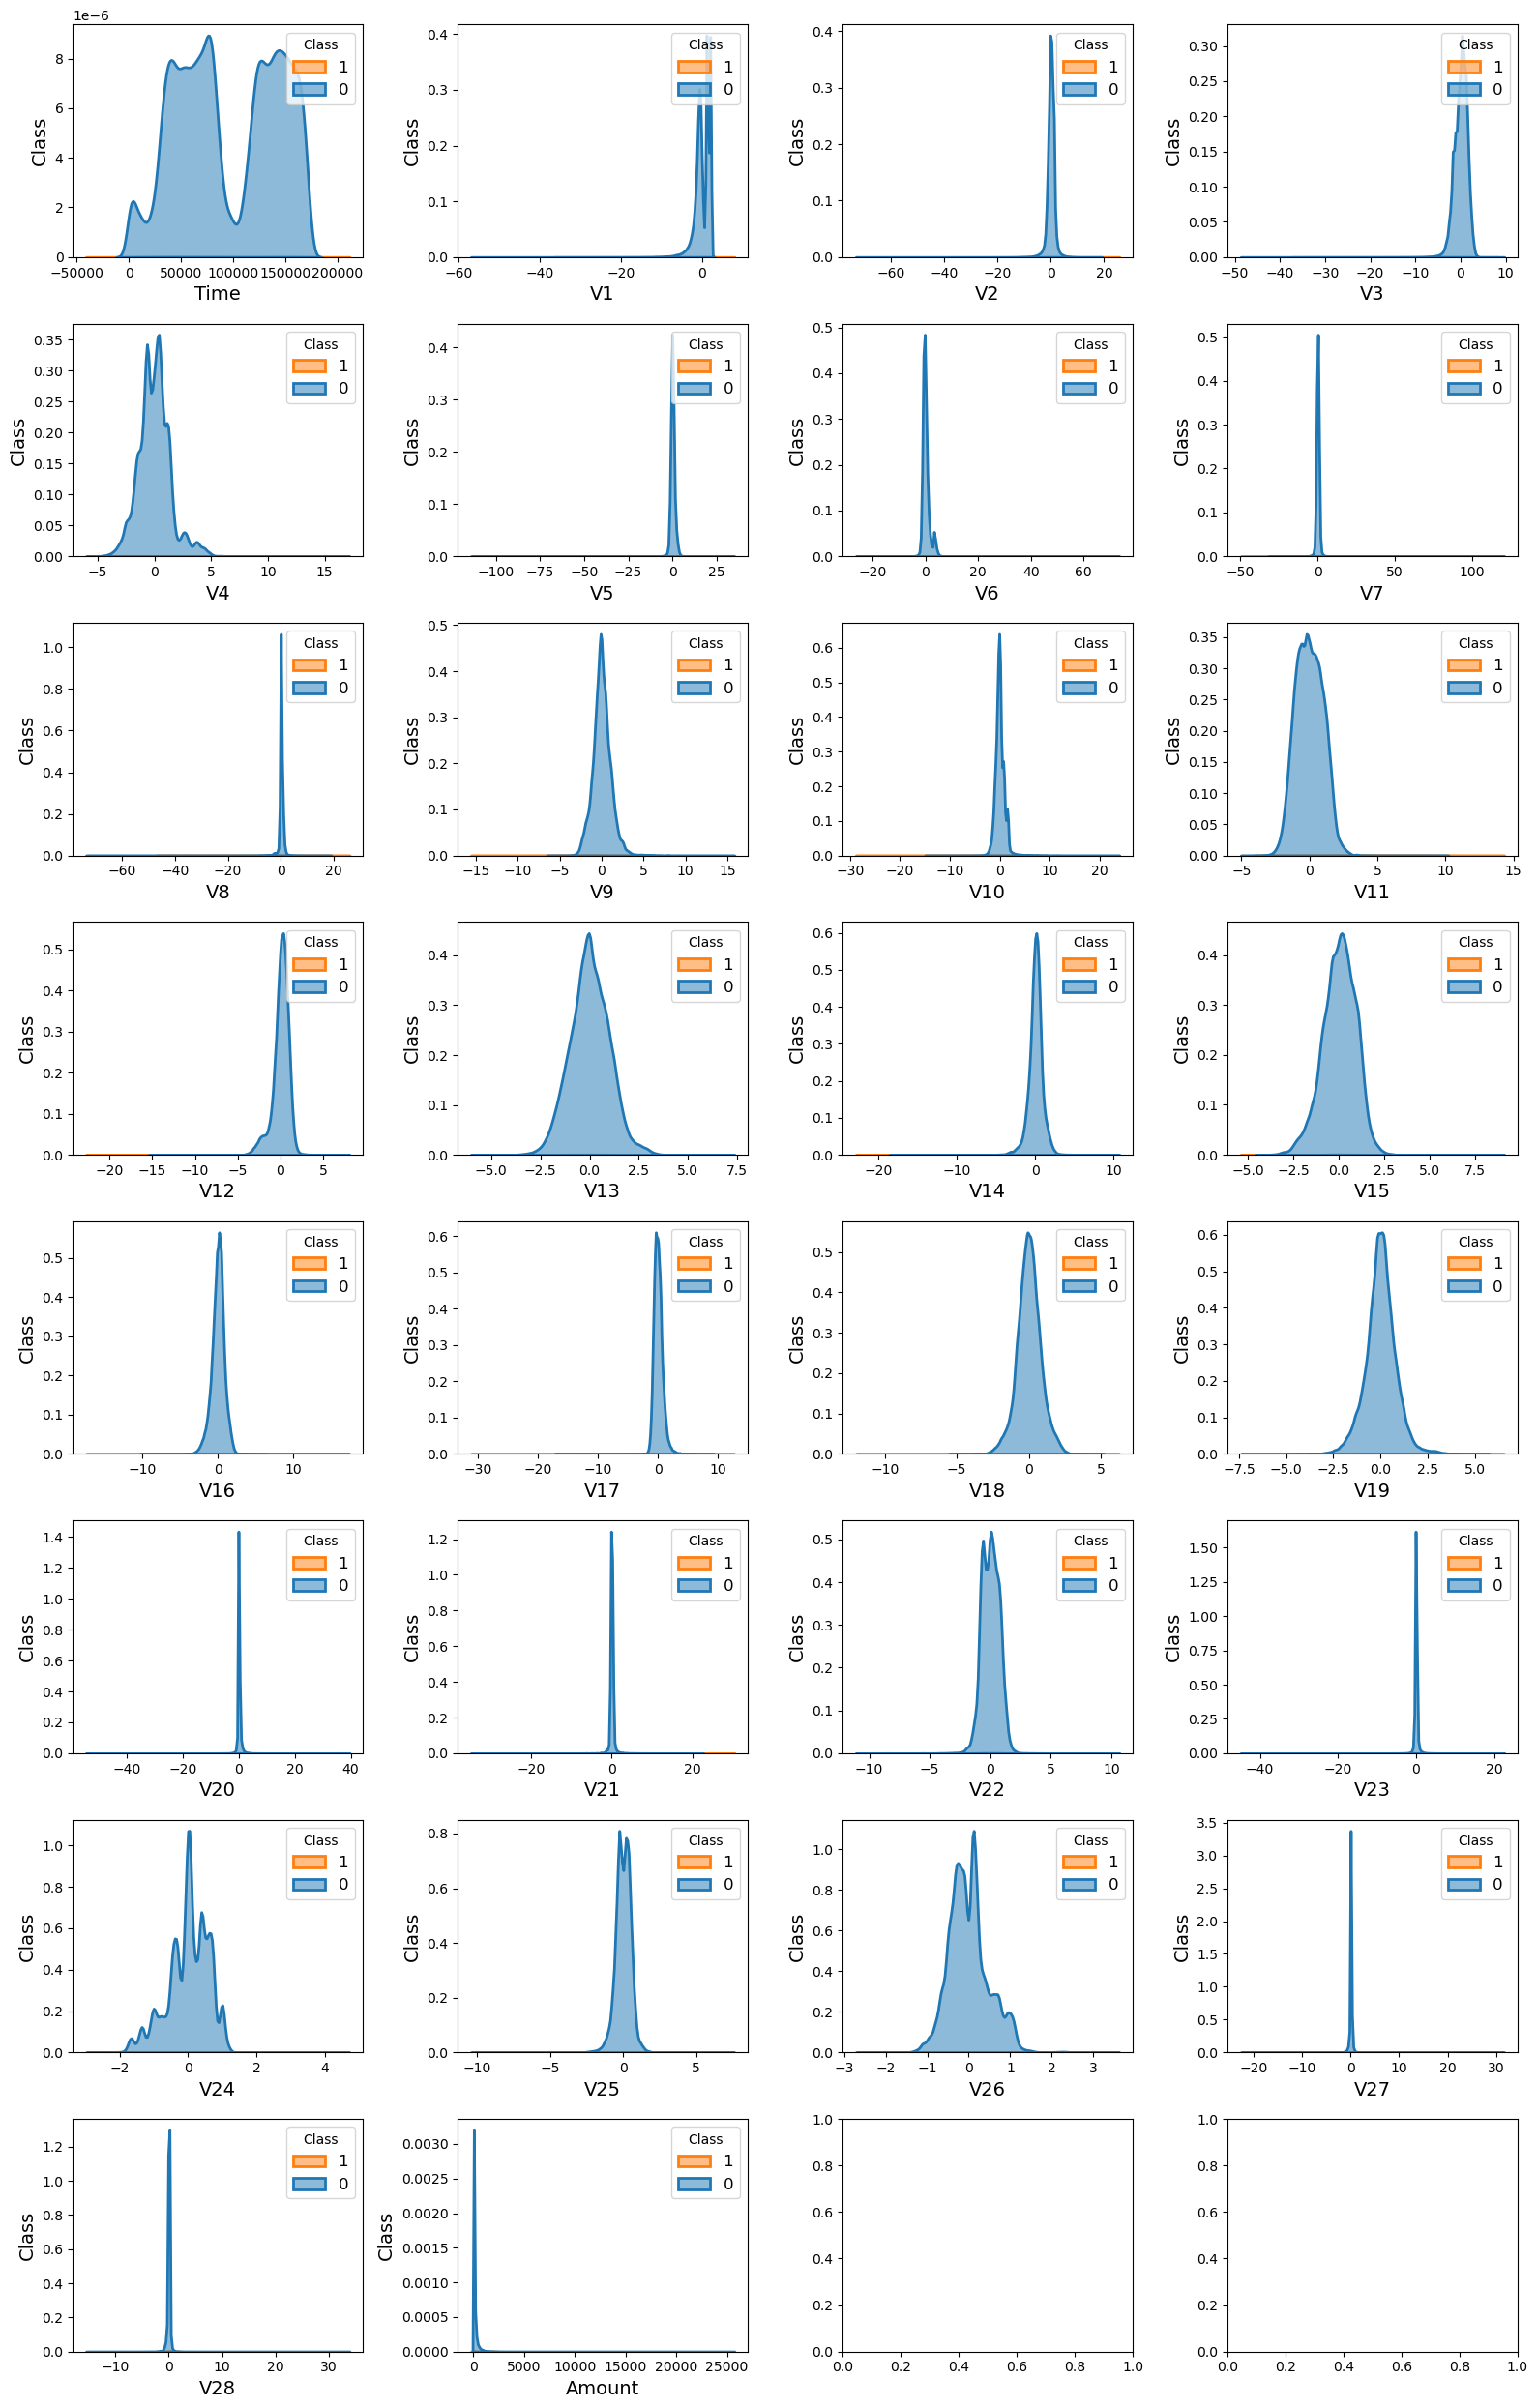

In [3]:
# 绘制各特征与Class的分布密度图（KDE）
fig, axes = plt.subplots(nrows = 8, ncols = 4, figsize = (16, 25))
for i, col_name in enumerate(data.columns.tolist()[:-1]):
    ax = axes[i//4, i%4]
    sns.kdeplot(data = data, x = col_name, hue = 'Class', fill = True, ax = ax, alpha = 0.5, linewidth = 2)
    ax.set_xlabel(col_name, fontsize = 14)
    ax.set_ylabel('Class', fontsize = 14)
    ax.legend([1,0], title = 'Class', fontsize=12)
plt.tight_layout()


[Text(0, 0.5, 'Time'),
 Text(0, 1.5, 'V1'),
 Text(0, 2.5, 'V2'),
 Text(0, 3.5, 'V3'),
 Text(0, 4.5, 'V4'),
 Text(0, 5.5, 'V5'),
 Text(0, 6.5, 'V6'),
 Text(0, 7.5, 'V7'),
 Text(0, 8.5, 'V8'),
 Text(0, 9.5, 'V9'),
 Text(0, 10.5, 'V10'),
 Text(0, 11.5, 'V11'),
 Text(0, 12.5, 'V12'),
 Text(0, 13.5, 'V13'),
 Text(0, 14.5, 'V14'),
 Text(0, 15.5, 'V15'),
 Text(0, 16.5, 'V16'),
 Text(0, 17.5, 'V17'),
 Text(0, 18.5, 'V18'),
 Text(0, 19.5, 'V19'),
 Text(0, 20.5, 'V20'),
 Text(0, 21.5, 'V21'),
 Text(0, 22.5, 'V22'),
 Text(0, 23.5, 'V23'),
 Text(0, 24.5, 'V24'),
 Text(0, 25.5, 'V25'),
 Text(0, 26.5, 'V26'),
 Text(0, 27.5, 'V27'),
 Text(0, 28.5, 'V28'),
 Text(0, 29.5, 'Amount'),
 Text(0, 30.5, 'Class')]

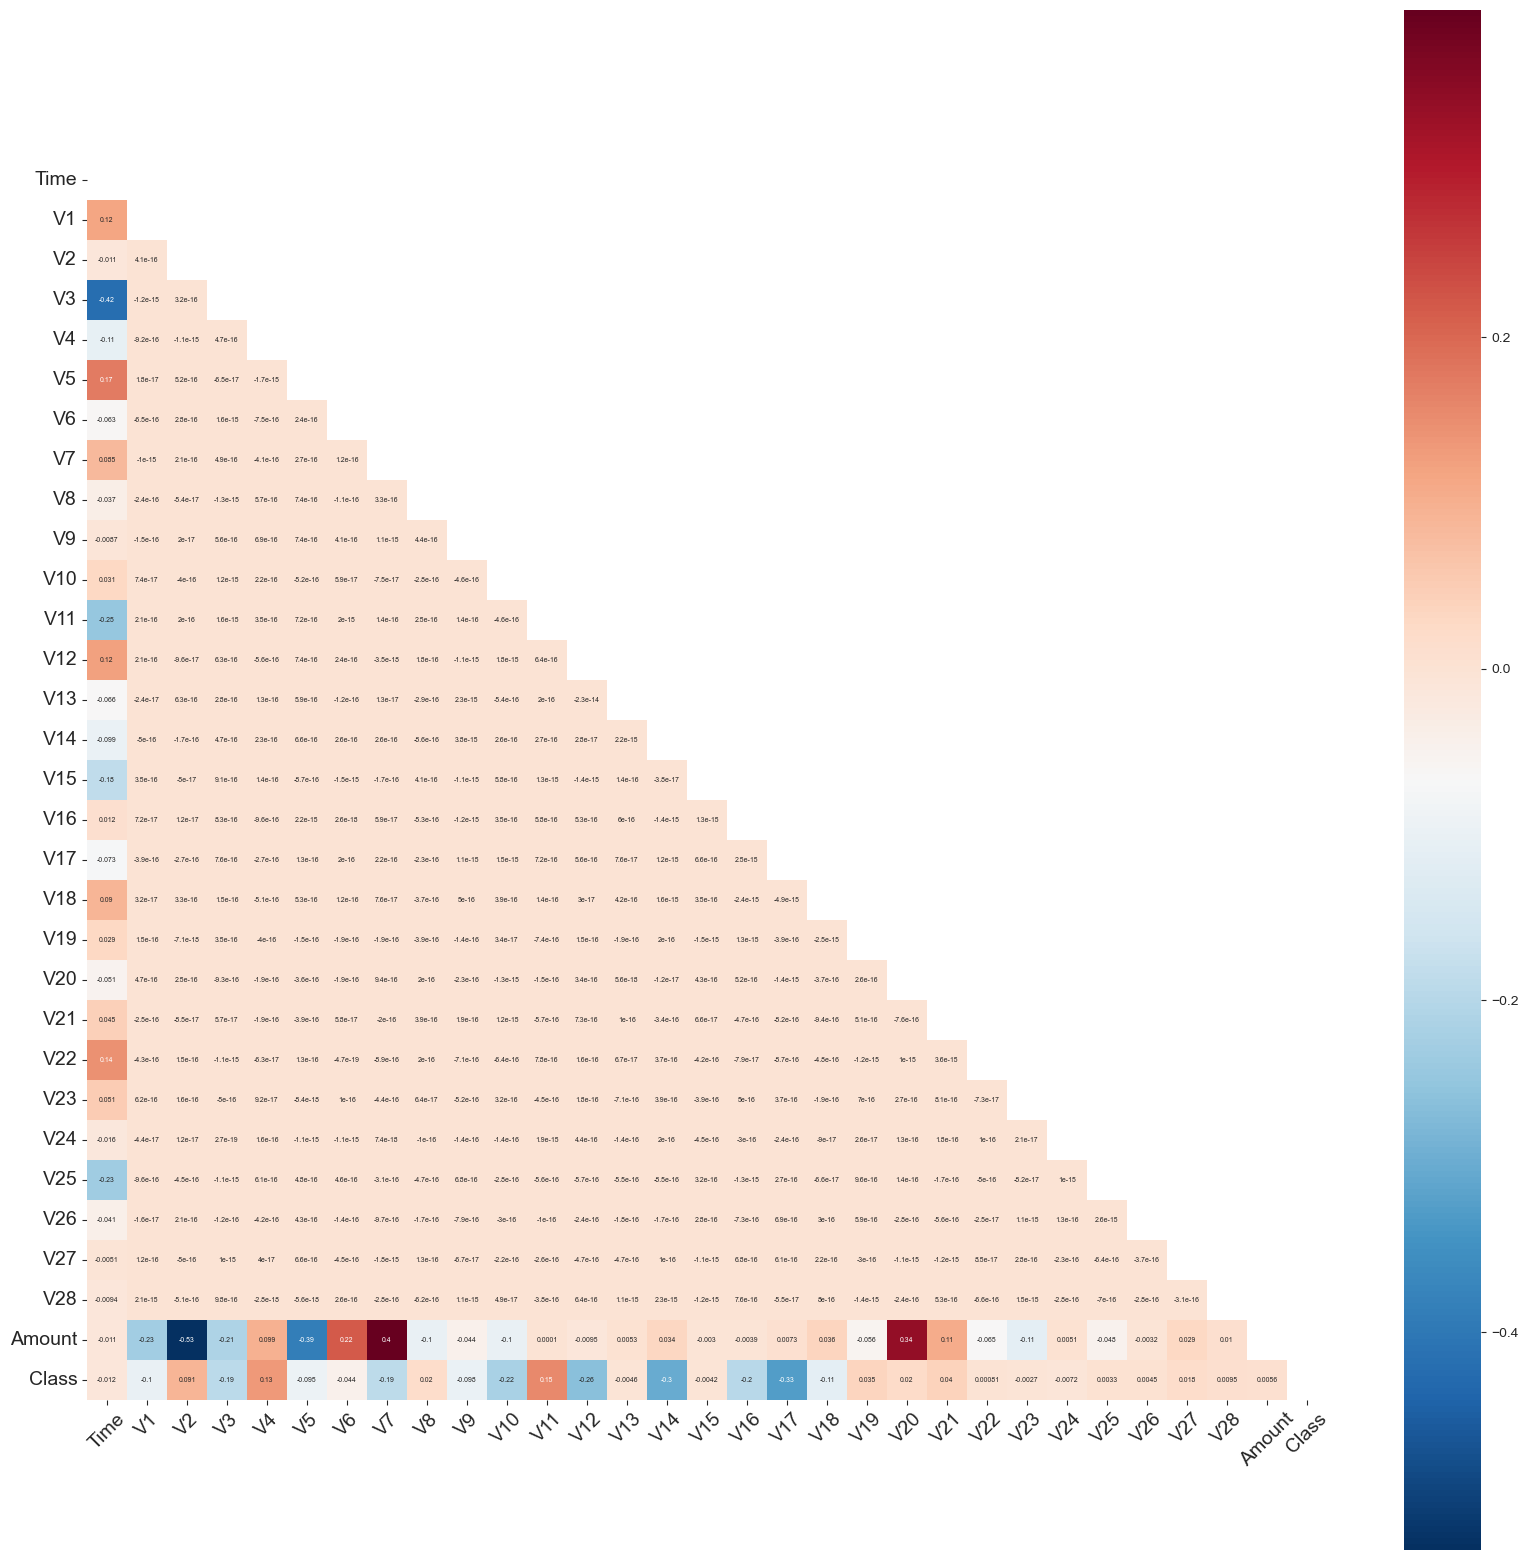

In [30]:
# 相关性热力图
corr_mat = data.corr()
# 为上三角矩阵生成掩码
mask = np.zeros_like(corr_mat, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

# 热力图
fig, ax = plt.subplots(figsize = (20,20))
sns.set_style('ticks')
ax = sns.heatmap(corr_mat, square = True, mask = mask, annot = True, annot_kws={'size':5}, cmap=plt.cm.RdBu_r)
ax.set_xticklabels(labels = data.columns, fontsize=14, rotation = 45)
ax.set_yticklabels(labels = data.columns, fontsize=14)


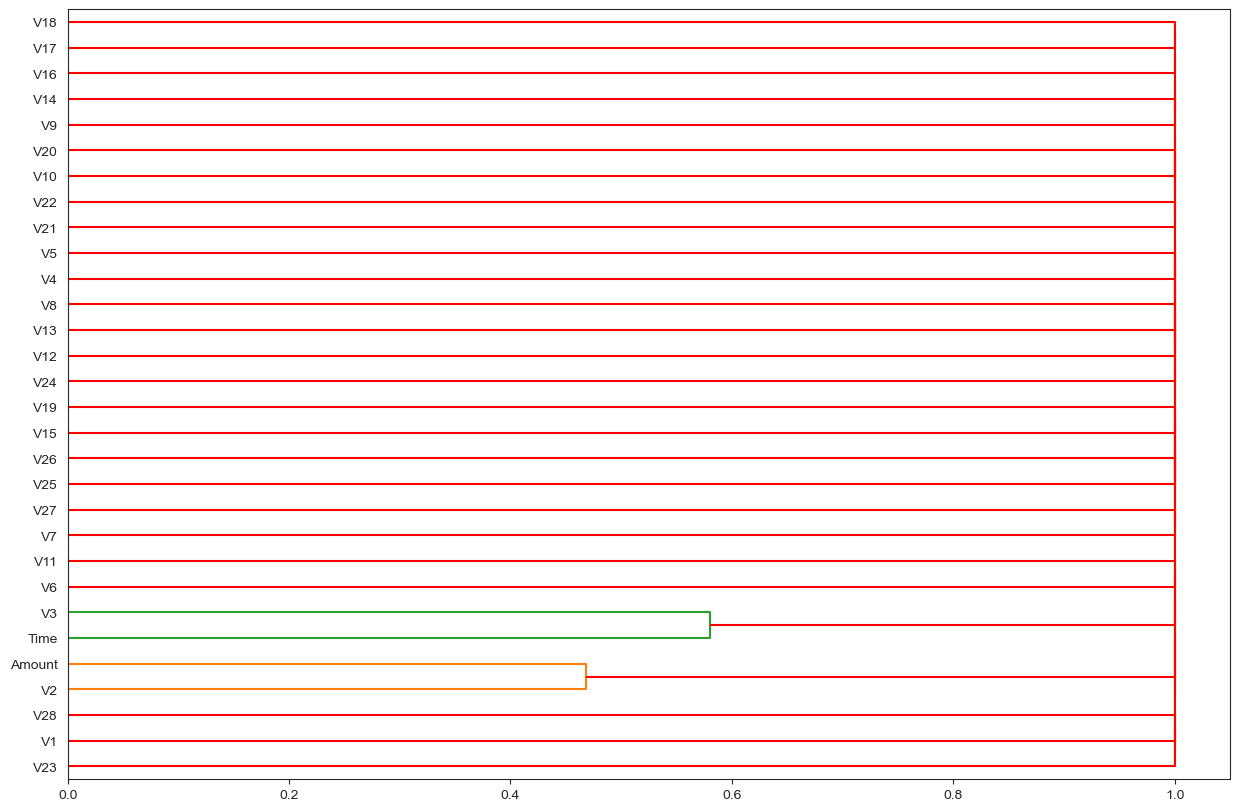

In [33]:
# 特征的层树
fig, ax = plt.subplots(figsize = (15, 10))
corr_feat = data.iloc[:,:-1].corr()
# squareform：用于距离方阵与距离向量相互转换的函数，要求方阵对角线为0
# 所以需要做1 - np.abs的转换
corr_mat_convert = 1 - np.abs(corr_feat)
Z = hierarchy.linkage(squareform(corr_mat_convert), 'complete')
dn = hierarchy.dendrogram(Z, labels = data.columns[:-1], ax = ax, above_threshold_color='#ff0000', orientation = 'right')

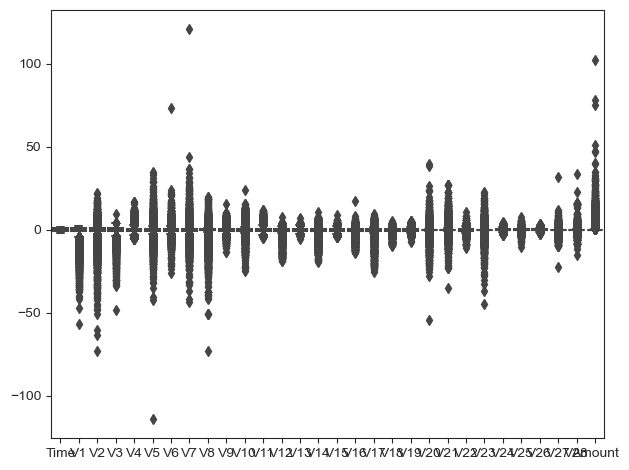

In [36]:
# 各特征
# for cla in data.iloc[-1]
sns.boxplot(data = data.iloc[:, :-1])
plt.tight_layout()

In [4]:
# 利用SMOTE+undersampling解决数据不平衡
OVER_RATE = 0.1
UNDER_RATE = 0.1
over = SMOTE(sampling_strategy = OVER_RATE)
under = RandomUnderSampler(sampling_strategy = UNDER_RATE)

steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)
X, y = pipeline.fit_resample(data.iloc[:,:-1], data.iloc[:, -1])

y.value_counts()

0    284310
1     28431
Name: Class, dtype: int64

In [5]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.8)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [6]:
# 使用optuna 搭配Stratified调优
skf = SKF(n_splits=5)

def objective_SVC(trial):
    # clf = trial.suggest_categorical('clf', ['LR','SVC','RF','xgb', 'lgb', 'SGD'])
    C = trial.suggest_float('C', 0.1, 10)
    gamma = trial.suggest_categorical('gamma', [0.01, 0.1, 1])
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear'])
    clf_obj = SVC(C = C, gamma = gamma, kernel = kernel)
    
    score = cross_val_score(clf_obj, X_train, y_train, cv = skf)
    accuracy = score.mean()
    return accuracy

def objective_LR(trial):
    # clf = trial.suggest_categorical('clf', ['LR','SVC','RF','xgb', 'lgb', 'SGD'])
    C = trial.suggest_float('C', 0.1, 10)
    clf_obj = LR(C = C)
    
    score = cross_val_score(clf_obj, X_train, y_train, cv = skf)
    accuracy = score.mean()
    return accuracy

def objective_RF(trial):
    # clf = trial.suggest_categorical('clf', ['LR','SVC','RF','xgb', 'lgb', 'SGD'])
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 5, 15)
    clf_obj = RF(n_estimators = n_estimators, 
                criterion = criterion,
                max_depth = max_depth)
    
    score = cross_val_score(clf_obj, X_train, y_train, cv = skf)
    accuracy = score.mean()
    return accuracy

def objective_XGB(trial):
    # clf = trial.suggest_categorical('clf', ['LR','SVC','RF','xgb', 'lgb', 'SGD'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 50, 1e3)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    clf_obj = xgb(learning_rate = learning_rate,
                n_estimators = n_estimators,
                max_depth = max_depth)
    
    score = cross_val_score(clf_obj, X_train, y_train, cv = skf)
    accuracy = score.mean()
    return accuracy

def objective_LGB(trial):
    # clf = trial.suggest_categorical('clf', ['LR','SVC','RF','xgb', 'lgb', 'SGD'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 1e2, 1e3)
    num_leaves = trial.suggest_int('num_leaves', 10, 50)
    clf_obj = lgb(learning_rate = learning_rate,
                n_estimators = n_estimators,
                num_leaves = num_leaves)
    
    score = cross_val_score(clf_obj, X_train, y_train, cv = skf)
    accuracy = score.mean()
    return accuracy


def objective_SGD(trial):
    max_iter = trial.suggest_int('max_iter', 1000, 2000)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    alpha = trial.suggest_loguniform('alpha', 1e-4, 0.1)
    clf_obj = SGD(max_iter = max_iter,
                penalty = penalty,
                alpha = alpha)

    score = cross_val_score(clf_obj, X_train, y_train, cv = skf)
    accuracy = score.mean()
    return accuracy


In [7]:
objective_list = [objective_LR, objective_RF, objective_SGD, objective_XGB, objective_LGB]
# objective_list = [objective_LR, objective_RF, objective_SVC, objective_SGD, objective_XGB, objective_LGB]
study_LR = optuna.create_study(direction='maximize', study_name = 'ccfp_LR', storage = 'sqlite:///example.db', load_if_exists=True)
study_RF = optuna.create_study(direction='maximize', study_name = 'ccfp_RF', storage = 'sqlite:///example.db', load_if_exists=True)
study_LGB = optuna.create_study(direction='maximize', study_name = 'ccfp_LGB', storage = 'sqlite:///example.db', load_if_exists=True)
study_XGB = optuna.create_study(direction='maximize', study_name = 'ccfp_XGB', storage = 'sqlite:///example.db', load_if_exists=True)
# study_SVC = optuna.create_study(direction='maximize', study_name = 'ccfp_SVC', storage = 'sqlite:///example.db', load_if_exists=True)
study_SGD = optuna.create_study(direction='maximize', study_name = 'ccfp_SGD', storage = 'sqlite:///example.db', load_if_exists=True)

study_list = [study_LR, study_RF, study_LGB, study_XGB, study_SGD]
# study_list = [study_LR, study_RF, study_LGB, study_XGB, study_SVC, study_SGD]

for study, objective in zip(study_list, objective_list):
    study.optimize(objective, n_trials = 5, thread = False) 
    print(f'Best hyperparameters: {study.best_params}')
    print(f'Best score: {study.best_value}')
    print(f'Best trial: {study.best_trial}', end = "\n\n")

[I 2023-08-28 17:12:40,331] Using an existing study with name 'ccfp_LR' instead of creating a new one.
[I 2023-08-28 17:12:40,388] Using an existing study with name 'ccfp_RF' instead of creating a new one.
[I 2023-08-28 17:12:40,446] Using an existing study with name 'ccfp_LGB' instead of creating a new one.
[I 2023-08-28 17:12:40,499] Using an existing study with name 'ccfp_XGB' instead of creating a new one.
[I 2023-08-28 17:12:40,542] Using an existing study with name 'ccfp_SGD' instead of creating a new one.
[I 2023-08-28 17:12:55,563] Trial 8 finished with value: 0.9847876840644018 and parameters: {'C': 4.3982485732716174}. Best is trial 0 with value: 0.9853032849334152.
[I 2023-08-28 17:12:55,566] Trial 6 finished with value: 0.9847876840644018 and parameters: {'C': 9.180317576883171}. Best is trial 0 with value: 0.9853032849334152.
[I 2023-08-28 17:12:55,832] Trial 5 finished with value: 0.9847876840644018 and parameters: {'C': 6.210351709810866}. Best is trial 0 with value: 0.9

Best hyperparameters: {'C': 6.797991239406379}
Best score: 0.9853032849334152
Best trial: FrozenTrial(number=0, state=1, values=[0.9853032849334152], datetime_start=datetime.datetime(2023, 8, 28, 16, 39, 53, 391929), datetime_complete=datetime.datetime(2023, 8, 28, 16, 40, 8, 531062), params={'C': 6.797991239406379}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10.0, log=False, low=0.1, step=None)}, trial_id=19, value=None)



[I 2023-08-28 17:48:19,143] Trial 5 finished with value: 0.9868221197474364 and parameters: {'n_estimators': 242, 'criterion': 'entropy', 'max_depth': 7}. Best is trial 5 with value: 0.9868221197474364.
[I 2023-08-28 17:52:12,622] Trial 4 finished with value: 0.9880731597641941 and parameters: {'n_estimators': 219, 'criterion': 'entropy', 'max_depth': 9}. Best is trial 4 with value: 0.9880731597641941.
[I 2023-08-28 18:30:10,666] Trial 8 finished with value: 0.9955913862785574 and parameters: {'n_estimators': 224, 'criterion': 'entropy', 'max_depth': 14}. Best is trial 8 with value: 0.9955913862785574.
[I 2023-08-28 18:39:06,166] Trial 6 finished with value: 0.9920580993948906 and parameters: {'n_estimators': 478, 'criterion': 'gini', 'max_depth': 13}. Best is trial 8 with value: 0.9955913862785574.
[I 2023-08-28 18:45:13,123] Trial 7 finished with value: 0.9956673284026676 and parameters: {'n_estimators': 477, 'criterion': 'entropy', 'max_depth': 14}. Best is trial 7 with value: 0.995

Best hyperparameters: {'n_estimators': 477, 'criterion': 'entropy', 'max_depth': 14}
Best score: 0.9956673284026676
Best trial: FrozenTrial(number=7, state=1, values=[0.9956673284026676], datetime_start=datetime.datetime(2023, 8, 28, 17, 13, 2, 570090), datetime_complete=datetime.datetime(2023, 8, 28, 18, 45, 13, 105840), params={'n_estimators': 477, 'criterion': 'entropy', 'max_depth': 14}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'criterion': CategoricalDistribution(choices=('entropy', 'gini')), 'max_depth': IntDistribution(high=15, log=False, low=5, step=1)}, trial_id=36, value=None)



[I 2023-08-28 18:45:19,429] Trial 3 finished with value: 0.9823415671744703 and parameters: {'max_iter': 1063, 'penalty': 'l1', 'alpha': 0.02254298806555783}. Best is trial 3 with value: 0.9823415671744703.
[I 2023-08-28 18:45:19,979] Trial 1 finished with value: 0.9828611591747757 and parameters: {'max_iter': 1144, 'penalty': 'l1', 'alpha': 0.013536776659833757}. Best is trial 1 with value: 0.9828611591747757.
[I 2023-08-28 18:45:23,954] Trial 4 finished with value: 0.9825334175311922 and parameters: {'max_iter': 1146, 'penalty': 'l1', 'alpha': 0.02121209459526205}. Best is trial 1 with value: 0.9828611591747757.
[I 2023-08-28 18:45:27,135] Trial 2 finished with value: 0.9836525504430856 and parameters: {'max_iter': 1521, 'penalty': 'l1', 'alpha': 0.0026001662544321304}. Best is trial 2 with value: 0.9836525504430856.
[I 2023-08-28 18:45:45,986] Trial 0 finished with value: 0.981909882225195 and parameters: {'max_iter': 1850, 'penalty': 'l1', 'alpha': 0.00023088504991052654}. Best is 

Best hyperparameters: {'max_iter': 1521, 'penalty': 'l1', 'alpha': 0.0026001662544321304}
Best score: 0.9836525504430856
Best trial: FrozenTrial(number=2, state=1, values=[0.9836525504430856], datetime_start=datetime.datetime(2023, 8, 28, 18, 45, 13, 225164), datetime_complete=datetime.datetime(2023, 8, 28, 18, 45, 27, 114010), params={'max_iter': 1521, 'penalty': 'l1', 'alpha': 0.0026001662544321304}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_iter': IntDistribution(high=2000, log=False, low=1000, step=1), 'penalty': CategoricalDistribution(choices=('l1', 'l2', 'elasticnet')), 'alpha': FloatDistribution(high=0.1, log=True, low=0.0001, step=None)}, trial_id=40, value=None)



[I 2023-08-28 18:49:50,253] Trial 0 finished with value: 0.9853272677456673 and parameters: {'learning_rate': 0.02023538331892153, 'n_estimators': 139, 'max_depth': 4}. Best is trial 0 with value: 0.9853272677456673.
[I 2023-08-28 18:59:24,863] Trial 1 finished with value: 0.9879052873472309 and parameters: {'learning_rate': 0.0054349768928164946, 'n_estimators': 208, 'max_depth': 7}. Best is trial 1 with value: 0.9879052873472309.
[I 2023-08-28 19:19:52,731] Trial 4 finished with value: 0.9873137417181679 and parameters: {'learning_rate': 0.06521578213702024, 'n_estimators': 779, 'max_depth': 6}. Best is trial 1 with value: 0.9879052873472309.
[I 2023-08-28 19:24:57,969] Trial 2 finished with value: 0.9879012906245531 and parameters: {'learning_rate': 0.02904279531575805, 'n_estimators': 865, 'max_depth': 7}. Best is trial 1 with value: 0.9879052873472309.
[I 2023-08-28 19:28:29,460] Trial 3 finished with value: 0.9909069836754799 and parameters: {'learning_rate': 0.00863672013640501,

Best hyperparameters: {'learning_rate': 0.00863672013640501, 'n_estimators': 661, 'max_depth': 10}
Best score: 0.9909069836754799
Best trial: FrozenTrial(number=3, state=1, values=[0.9909069836754799], datetime_start=datetime.datetime(2023, 8, 28, 18, 45, 46, 95692), datetime_complete=datetime.datetime(2023, 8, 28, 19, 28, 29, 405456), params={'learning_rate': 0.00863672013640501, 'n_estimators': 661, 'max_depth': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1)}, trial_id=46, value=None)



[I 2023-08-28 19:30:02,968] Trial 1 finished with value: 0.9821417257687012 and parameters: {'learning_rate': 0.5180505210271025, 'n_estimators': 980, 'num_leaves': 34}. Best is trial 1 with value: 0.9821417257687012.
[I 2023-08-28 19:30:16,563] Trial 2 finished with value: 0.9997761717082548 and parameters: {'learning_rate': 0.1292782491381226, 'n_estimators': 644, 'num_leaves': 49}. Best is trial 2 with value: 0.9997761717082548.
[I 2023-08-28 19:30:45,321] Trial 0 finished with value: 0.989200292112214 and parameters: {'learning_rate': 0.001125663150354763, 'n_estimators': 770, 'num_leaves': 46}. Best is trial 2 with value: 0.9997761717082548.
[I 2023-08-28 19:30:46,831] Trial 4 finished with value: 0.974183746414397 and parameters: {'learning_rate': 0.5211301061639065, 'n_estimators': 303, 'num_leaves': 49}. Best is trial 2 with value: 0.9997761717082548.
[I 2023-08-28 19:30:49,913] Trial 3 finished with value: 0.9909069828767103 and parameters: {'learning_rate': 0.0013684682180616

Best hyperparameters: {'learning_rate': 0.1292782491381226, 'n_estimators': 644, 'num_leaves': 49}
Best score: 0.9997761717082548
Best trial: FrozenTrial(number=2, state=1, values=[0.9997761717082548], datetime_start=datetime.datetime(2023, 8, 28, 19, 28, 29, 533715), datetime_complete=datetime.datetime(2023, 8, 28, 19, 30, 16, 526301), params={'learning_rate': 0.1292782491381226, 'n_estimators': 644, 'num_leaves': 49}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'num_leaves': IntDistribution(high=50, log=False, low=10, step=1)}, trial_id=50, value=None)



In [ ]:
# ensemble_results = pd.concat([Bagging_test, xgb_test], axis = 1)
# [I 2023-08-28 01:25:56,396] Trial 8 finished with value: 0.9791400182576805 and parameters: {'clf': 'SGD', 'max_iter': 1443, 'penalty': 'l1', 'alpha': 0.05524914086818416}. Best is trial 1 with value: 0.9952956140231644.
# [I 2023-08-28 02:14:27,219] Trial 9 finished with value: 0.9996282858601276 and parameters: {'clf': 'SVC', 'C': 9.5412932069987, 'gamma': 0.1, 'kernel': 'rbf'}. Best is trial 9 with value: 0.9996282858601276.
# [I 2023-08-28 02:29:11,189] Trial 10 finished with value: 0.9917743149112228 and parameters: {'clf': 'xgb', 'learning_rate': 0.014551724808068347, 'n_estimators': 564, 'max_depth': 10}. Best is trial 9 with value: 0.9996282858601276.

result_df = pd.DataFrame(columns = ['Accuracy', 'F1-score', 'Recall', 'Precision', 'AUC_ROC'],
                         index = ['LR', 'RF', 'SGD', 'SVC', 'XGB', 'LingGBM'])

In [29]:
SVC_best_estimator = SVC(**{'C': 9.5412932069987, 'gamma': 0.1, 'kernel': 'rbf'})
SVC_best_estimator.fit(X_train, y_train)

SVC(C=9.5412932069987, gamma=0.1)

In [25]:
LR_best_estimator = LR(**study_LR.best_trial.params)
RF_best_estimator = RF(**study_RF.best_trial.params)
# SVC_best_estimator = SVC(**study_SVC.best_trial.params)
# 这里之前多线程使得结果错乱
SGD_best_estimator = SGD(**study_LGB.best_trial.params)
XGB_best_estimator = xgb(**study_XGB.best_trial.params)
LGB_best_estimator = lgb(**study_SGD.best_trial.params)

best_models = [LR_best_estimator, RF_best_estimator, 
                SGD_best_estimator, 
               XGB_best_estimator, LGB_best_estimator]

for model in best_models:
    model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 22790, number of negative: 227402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 250192, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091090 -> initscore=-2.300398
[LightGBM] [Info] Start training from score -2.300398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [36]:
print(study_LR.best_trial.params)
print(study_RF.best_trial.params)
print(study_SGD.best_trial.params)
print(study_XGB.best_trial.params)
print(study_LGB.best_trial.params)

{'C': 6.797991239406379}
{'n_estimators': 477, 'criterion': 'entropy', 'max_depth': 14}
{'learning_rate': 0.1292782491381226, 'n_estimators': 644, 'num_leaves': 49}
{'learning_rate': 0.00863672013640501, 'n_estimators': 661, 'max_depth': 10}
{'max_iter': 1521, 'penalty': 'l1', 'alpha': 0.0026001662544321304}


In [14]:
def caculate(models, X_test, y_test):
    # 计算各种参数的值
    accuracy_results = []
    F1_score_results = []
    Recall_results = []
    Precision_results = []
    AUC_ROC_results = []
    
    for model in models:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) # 计算准确度
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred) # 计算：精确度，召回率，f1_score
        AUC_ROC = roc_auc_score(y_test, y_pred) # 计算ROC, AUC
        
        # 保存计算值
        accuracy_results.append(accuracy)
        F1_score_results.append(f1_score)
        Recall_results.append(recall)
        AUC_ROC_results.append(AUC_ROC)
        Precision_results.append(precision)
        
    return accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results

In [40]:
# 看情况是否添加SVC
best_models.append(SVC_best_estimator)
accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results = caculate(best_models, X_test, y_test)
result_df = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Recall', 'Precision', 'AUC_ROC'],
                         index=['LR','RF','SGD','XGB', 'LGB', 'SVC'])
# 将各项值放入到DataFrame中
result_df['Accuracy'] = accuracy_results
result_df['F1-score'] = F1_score_results
result_df['Recall'] = Recall_results
result_df['Precision'] = Precision_results
result_df['AUC_ROC'] = AUC_ROC_results

In [41]:
result_df

,Accuracy,F1-score,Recall,Precision,AUC_ROC
LR,0.984924,"[0.9917672839021153, 0.9106584557081951]","[0.9981022000421733, 0.8519765998936358]","[0.9855122755270235, 0.978021978021978]",0.925039
RF,0.996195,"[0.9979129397734049, 0.9784849032724643]","[0.9998418500035144, 0.9594043609289133]","[0.9959914577790225, 0.9983397897066962]",0.979623
SGD,0.982941,"[0.9906620574979215, 0.9015046616818979]","[0.994570183453996, 0.8656266619393724]","[0.9867845249925903, 0.9404853620955316]",0.930098
XGB,0.991207,"[0.9951888591472909, 0.9489795918367347]","[0.9995782666760386, 0.9067541216096436]","[0.9908378331301168, 0.9953298307063632]",0.953166
LGB,0.999808,"[0.9998945574047062, 0.9989373007438894]","[0.999806705559851, 0.9998227264669385]","[0.9999824246897958, 0.9980534418686958]",0.999815
SVC,0.999648,"[0.9998066851780253, 0.9980520630423234]","[0.9997012722288606, 0.9991136323346924]","[0.999912120359955, 0.9969927472138688]",0.999407
